##华为手表睡眠分期

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import json

In [2]:
# 设置中文字体属性
font_path = '../data/SimHei.ttf'
prop = FontProperties(fname=font_path, size=16)

In [3]:
def transfer(timestamp):
    '''
    将时间戳转换为日期时间。

    该函数将以纳秒为单位的时间戳转换为日期时间对象。

    参数:
        timestamp (int): 以纳秒为单位的时间戳。

    返回:
        datetime: 对应的日期时间对象。
    '''
    # 将时间戳从纳秒转换为秒，并生成相应的日期时间对象
    return datetime.fromtimestamp(timestamp / 1000000000)


In [4]:
def read_data(file_path):
    '''
    读取JSON文件并提取数据。

    该函数从指定的文件路径读取JSON文件，并将其内容解析为Python字典或列表。

    参数:
        file_path (str): JSON文件的路径。

    返回:
        dict or list: 从JSON文件中解析的数据。
    '''
    # 打开指定路径的JSON文件，并读取其内容
    with open(file_path, 'r') as f:
        # 使用json.load将文件内容解析为Python字典或列表
        data = json.load(f)
    
    # 返回解析后的数据
    return data


In [5]:
def extract_sleep_data(data):
    '''
    手表提取睡眠分期数据。

    该函数从提供的手表记录数据中提取睡眠分期和睡眠日志数据

    参数:
        data (dict): 包含睡眠日志和睡眠分期的字典数据。

    返回:
        tuple: 包含两个元素的元组:
            - sample_points (list): 睡眠分期数据的采样点。
            - sleep_data (dict): 睡眠日志数据。
    '''
    # 提取健康记录中睡眠数据的采样点
    sample_points = data["healthRecords"][0]["subData"]['com.huawei.continuous.sleep.fragment']['samplePoints']
    
    # 提取健康记录中的睡眠记录值
    sleep_data = data["healthRecords"][0]["value"]
    
    # 返回采样点和睡眠记录值
    return sample_points, sleep_data


In [6]:
def process_sample_points(sample_points):
    '''
    处理样本点以提取时间和阶段。

    该函数从样本点数据中提取时间和阶段信息，并将时间戳转换为日期时间对象。

    参数:
        sample_points (list): 包含样本点的列表，每个样本点包含开始时间和阶段值。

    返回:
        tuple: 包含两个元素的元组:
            - times (list): 转换后的日期时间对象列表。
            - stages (list): 对应的阶段值列表。
    '''
    times = []
    stages = []
    
    # 遍历样本点列表
    for point in sample_points:
        # 提取样本点的开始时间，并转换为日期时间对象
        time = point["startTime"]
        date_time = datetime.fromtimestamp(time / 1000000000)
        times.append(date_time)
        
        # 提取阶段值并添加到阶段列表
        stage = point["value"][0]["integerValue"]
        stages.append(stage)
    
    # 返回提取的时间和阶段列表
    return times, stages


In [7]:
def map_stages(stages):
    '''
    将阶段映射到颜色代码。

    该函数根据给定的阶段值，将每个阶段值映射到对应的颜色代码。颜色代码的映射规则如下：
    - 阶段值 1 映射到颜色代码 2
    - 阶段值 2 映射到颜色代码 3
    - 阶段值 3 映射到颜色代码 1
    - 阶段值 4 映射到颜色代码 4

    参数:
        stages (list): 包含阶段值的列表，阶段值为整数。

    返回:
        list: 对应的颜色代码列表。
    '''
    return [2 if x == 1 else 3 if x == 2 else 1 if x == 3 else 4 for x in stages]


In [8]:
def calculate_stage_durations(stage_values):
    '''
    计算每个睡眠阶段的时长。

    该函数计算不同睡眠阶段的时长，基于阶段值的出现次数：
    - 阶段值 1 代表浅睡眠
    - 阶段值 2 代表快速眼动睡眠（REM）
    - 阶段值 3 代表深睡眠
    - 阶段值 4 代表清醒状态

    参数:
        stage_values (list): 包含阶段值的列表，每个阶段值为整数。

    返回:
        tuple: 包含四个元素的元组，分别是每个睡眠阶段的时长（出现次数）：
            - light_sleep_time (int): 浅睡眠的时长
            - rem_sleep_time (int): 快速眼动睡眠的时长
            - deep_sleep_time (int): 深睡眠的时长
            - awake_time (int): 清醒状态的时长
    '''
    # 计算各个阶段的出现次数
    light_sleep_time = stage_values.count(1)
    rem_sleep_time = stage_values.count(2)
    deep_sleep_time = stage_values.count(3)
    awake_time = stage_values.count(4)
    
    # 返回计算结果
    return light_sleep_time, rem_sleep_time, deep_sleep_time, awake_time


In [9]:
def hm(total_minutes):
    '''
    将分钟转换为小时和分钟。

    该函数将总分钟数转换为小时和分钟的形式，以便更易读的表示时间。

    参数:
        total_minutes (int): 总分钟数。

    返回:
        tuple: 包含两个元素的元组:
            - hours (int): 计算得到的小时数。
            - minutes (int): 计算得到的分钟数。
    '''
    # 计算小时数，使用整数除法
    hours = total_minutes // 60
    # 计算剩余的分钟数
    minutes = total_minutes % 60
    
    # 返回小时和分钟
    return hours, minutes


In [10]:
import matplotlib.pyplot as plt

def plot_sleep_stages(times, stage_values, total_sleep_duration, deep_sleep_duration, light_sleep_time, rem_sleep_time, awake_time,path):
    '''
    绘制睡眠阶段图表。

    该函数绘制睡眠阶段图表，其中不同的睡眠阶段用不同的颜色表示。图表包括总睡眠时间、深睡眠时间、浅睡眠时间、快速眼动（REM）时间和清醒时间。

    参数:
        times (list): 包含时间戳的列表，用于显示在x轴上。
        stage_values (list): 包含睡眠阶段值的列表，对应于每个时间戳的睡眠阶段。
        total_sleep_duration (int): 总睡眠时间（分钟）。
        deep_sleep_duration (int): 深睡眠时间（分钟）。
        light_sleep_time (int): 浅睡眠时间（分钟）。
        rem_sleep_time (int): 快速眼动（REM）睡眠时间（分钟）。
        awake_time (int): 清醒时间（分钟）。
    '''
    # 定义每个睡眠阶段的颜色
    colors = ['purple', 'r', 'pink', 'y']
    
    # 创建图表
    plt.figure(figsize=(20, 7))
    
    # 初始化当前阶段和开始索引
    current_stage = stage_values[0]
    start_idx = 0

    # 遍历阶段值以绘制图表
    for i in range(1, len(stage_values)):
        # 检查当前阶段是否发生变化
        if stage_values[i] != current_stage:
            # 绘制阶段变化的部分
            plt.plot(range(start_idx, i), stage_values[start_idx:i], color=colors[current_stage-1])
            plt.fill_between(range(start_idx, i), [current_stage - 1] * (i - start_idx), [current_stage] * (i - start_idx), color=colors[current_stage - 1], step="pre")
            start_idx = i
            current_stage = stage_values[i]

    # 绘制最后一个阶段的部分
    plt.plot(range(start_idx, len(stage_values)), stage_values[start_idx:], color=colors[current_stage-1])
    plt.fill_between(range(start_idx, len(stage_values)), [current_stage - 1] * (len(stage_values) - start_idx), [current_stage] * (len(stage_values) - start_idx), color=colors[current_stage - 1], step="pre")

    # 将总睡眠时间转换为小时和分钟
    h, m = hm(total_sleep_duration)

    # 设置图表标题、标签和刻度
    plt.title(f'华为手表睡眠分期结果\n 总睡眠时间：{h}小时{m}分钟 深睡时间：{deep_sleep_duration}min 浅睡时间：{light_sleep_time}min  快速眼动时间：{rem_sleep_time}min    清醒时间：{awake_time}min', fontproperties=prop)
    plt.xlabel('时间', fontproperties=prop)
    plt.ylabel('阶段', fontproperties=prop)
    plt.yticks([1, 2, 3, 4], ['深睡', '浅睡', '快速眼动', '清醒'], fontproperties=prop)
    plt.xticks([0, len(stage_values)], [times[0], times[-1]], rotation=5, ha='right', va='top', fontproperties=prop)

    # 保存并显示图表
    plt.savefig(path)
    plt.show()


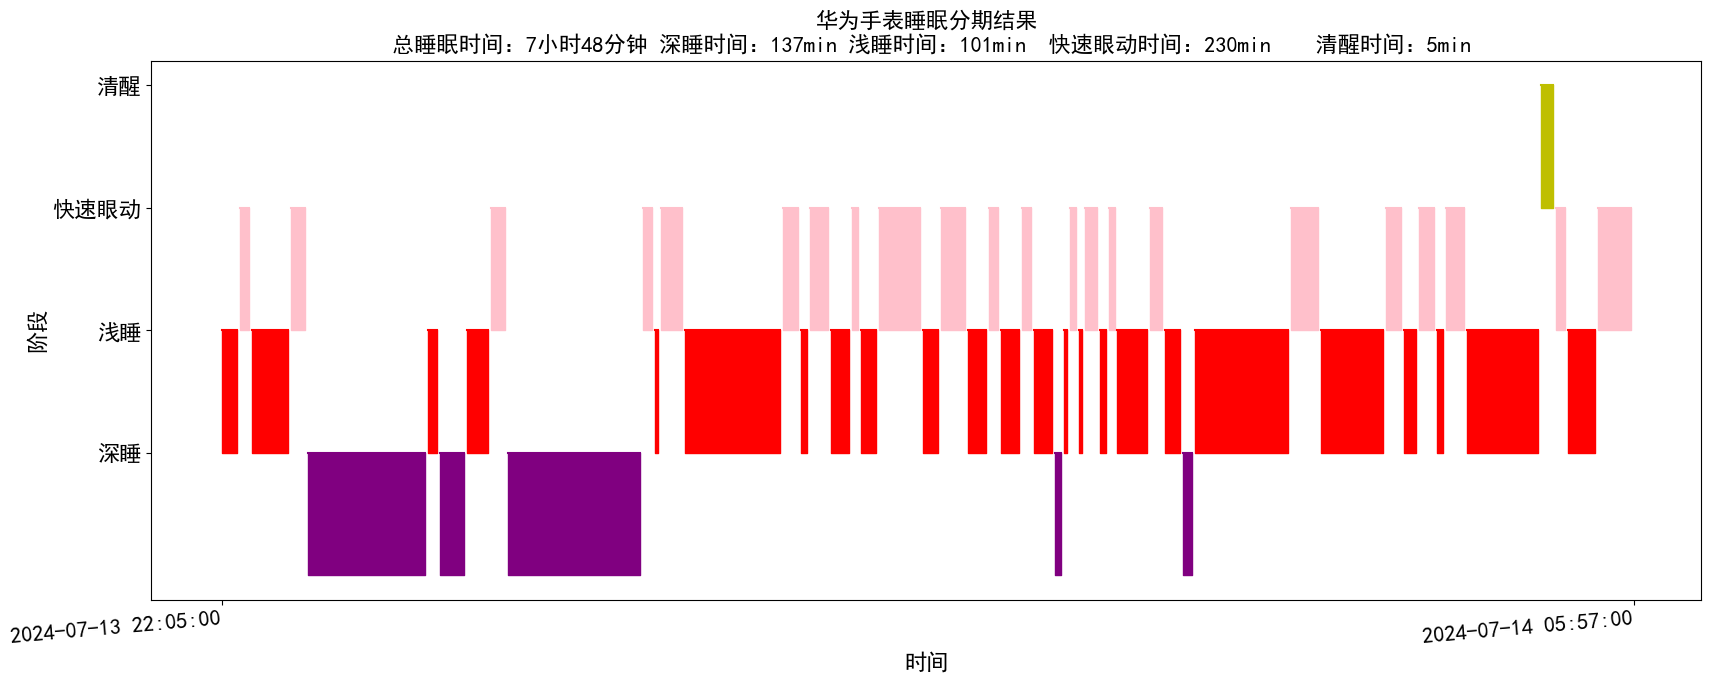

In [11]:
if __name__ == "__main__":
    file_path = "../data/Sleep_Staging.json"
    save_path = "../result/华为手表睡眠分期.png"
    data = read_data(file_path)
    sample_points, sleep_data = extract_sleep_data(data)
    times, stages = process_sample_points(sample_points)
    stage_values = map_stages(stages)
    light_sleep_time, rem_sleep_time, deep_sleep_time, awake_time = calculate_stage_durations(stage_values)
    total_sleep_duration = sleep_data[6]["integerValue"]  # 总睡眠时长
    plot_sleep_stages(times, stage_values, total_sleep_duration, deep_sleep_time, light_sleep_time, rem_sleep_time, awake_time,save_path)
